## Initialization

In [37]:
!pip -q install wfdb imbalanced-learn

import os
import wfdb
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [38]:
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  # project_directory='/content/drive/MyDrive/kuliah/vlsi/Data_Training/'
  project_directory='/content/drive/MyDrive/Data_Training/'
  os.chdir(project_directory)
except:
  pass

Mounted at /content/drive


## Data Visualization

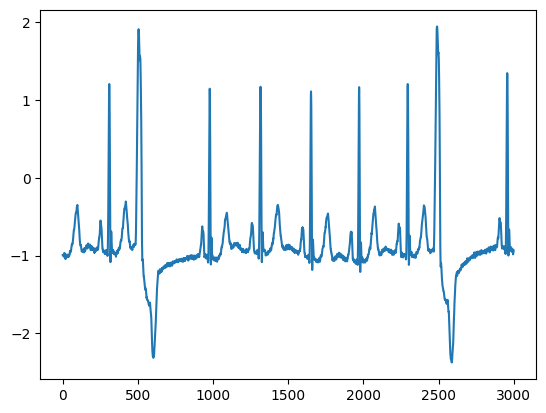

In [39]:
# Specify the record name and path
record_name = '119'
record_path = f'./mit-bih-arrhythmia-database-1.0.0/{record_name}'

# Read the ECG record. We can optionally pass in the `sampto` parameter to read a specific number of samples. Let's try 3000.
record = wfdb.rdrecord(record_path, sampto=3000)

# Extract the ECG signal from the first lead of the record
ecg_signal = record.p_signal[:,0]

# Plotting the ECG signal
plt.plot(ecg_signal)

## Data Preprocessing

In [40]:
record_name = '101'
record_path = f'./mit-bih-arrhythmia-database-1.0.0/{record_name}'
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'atr')

In [41]:
peaks = annotation.sample
symbols = annotation.symbol

In [42]:
print(peaks[:10])
print(symbols[:10])

[   7   83  396  711 1032 1368 1712 2036 2349 2662]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [43]:
data_path = './mit-bih-arrhythmia-database-1.0.0/'
record_list = wfdb.get_record_list('mitdb')

Data Preprocessing
- Break signal into segments of 10 R-R intervals
- Filter them so that only two classes remain (Normal ECG & Arrhythmic ECG)

- Normal ECG
    - Label = 0
    - All R-R intervals are from normal beats, annotated with 'N'
- Arrhythmic ECG
  - Label = 1
  - At least 2/10 beats are annotated with the 'V' symbol

In [44]:
X = []  # R-R intervals
Y = []  # labels (normal = 0, arrhythmic = 1)

window_size = 10

for record_name in record_list:
  # Load the signal and annotations
  annotation = wfdb.rdann(os.path.join(data_path, record_name), 'atr')
  # print("annotation", annotation)

  # Detect peaks
  peaks = annotation.sample
  # print("peaks:",peaks)

  # Get R-R intervals
  intervals = np.diff(peaks)
  # print("intervals:", intervals)

  # Normalize the intervals
  normalized_intervals = intervals / intervals.max()
  # print("normalized_intervals:", normalized_intervals)

  # Break up the intervals into segments of 10
  for i in range(len(intervals) - window_size +1):
    # Get the annotations and intervals for the current window
    window_annotations = annotation.symbol[i:i + window_size]
    window_intervals = normalized_intervals[i:i + window_size]

    # Count of abnormal beats
    abnormal_count = sum(1 for ann in window_annotations if ann == 'V')

    # Select windows that are either all 'N' or have at least 2 'V's
    if all(ann == 'N' for ann in window_annotations) or (abnormal_count >= 2):
      X.append(window_intervals)
      Y.append(abnormal_count >= 2)

In [45]:
X = np.array(X)
Y = np.array(Y)

## Data Balancing

Text(0, 0.5, 'Count')

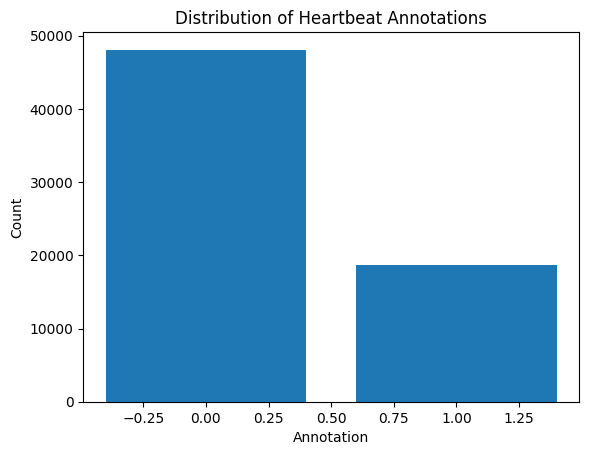

In [46]:
annotation_counter = Counter()
annotation_counter.update(Y)

plt.bar(annotation_counter.keys(), annotation_counter.values())
plt.title('Distribution of Heartbeat Annotations')
plt.xlabel('Annotation')
plt.ylabel('Count')

Pada data di atas, terlihat data normal heartbeat lebih dari 2x jumlahnya dibanding arrhythmic heartbeat

In [47]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [48]:
print(X_train)
print(Y_train)
print(len(X_train))
print(len(Y_train))

[[0.61344538 0.37394958 0.63445378 ... 0.34663866 0.56302521 0.56722689]
 [0.58922559 0.45117845 0.53030303 ... 0.46296296 0.34680135 0.55050505]
 [0.57882353 0.54823529 0.55058824 ... 0.45411765 0.6        0.42823529]
 ...
 [0.53164557 0.51424051 0.26424051 ... 0.41139241 0.28164557 0.5585443 ]
 [0.63390663 0.61670762 0.65601966 ... 0.67076167 0.67567568 0.67076167]
 [0.49087894 0.52736318 0.55223881 ... 0.50414594 0.53399668 0.55887231]]
[ True False  True ...  True False False]
53425
53425


38494.0
76988


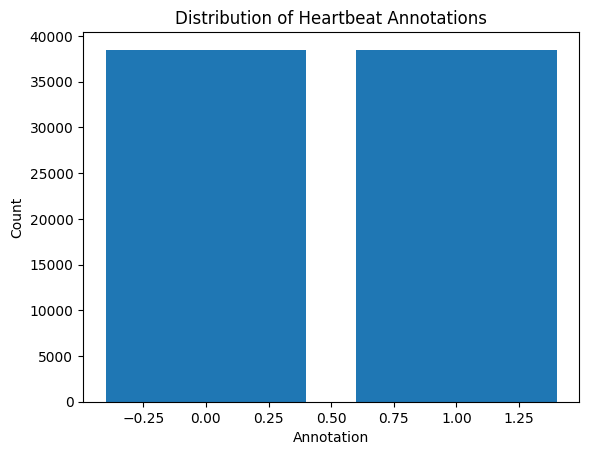

In [49]:
# Fix class imbalance
smote = SMOTE()

# Fit SMOTE to the training data
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

print(len(X_train_smote)/2)
print(len(Y_train_smote))

annotation_smote_counter = Counter()
annotation_smote_counter.update(Y_train_smote)

plt.bar(annotation_smote_counter.keys(), annotation_smote_counter.values())
plt.title('Distribution of Heartbeat Annotations')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.show()

## Model Training

In [50]:
# # Define the model
# # Simple 3-;ayer neural network
# model = Sequential([
#     Dense(16, input_dim=window_size, activation='relu'),
#     Dense(8, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

In [51]:
# Model terbaru
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, Y_train, Y_test are already defined

# Parameters
input_dim = X_train.shape[1]  # Number of features in your data
latent_dim = 1  # Dimension of the latent space
intermediate_dim = 6  # Size of the hidden layers

# Encoder
inputs = Input(shape=(input_dim,), name='input_encoder')
h = Dense(intermediate_dim, activation='softplus', name='intermediate_layer')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(h)
# z_log_var = Dense(latent_dim, name='z_log_var')(h)
z_var = Dense(latent_dim, name='z_var',activation='softplus')(h)

# Reparameterization trick
def sampling(args):
    # z_mean, z_log_var = args
    z_mean, z_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    # return z_mean + K.exp(0.5 * z_log_var) * epsilon
    return z_mean + K.sqrt(z_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_var])

# Misalkan Y_train berisi label biner (True/False)
num_classes = 2  # Ubah sesuai dengan jumlah kelas yang Anda miliki
Y_train_encoded = to_categorical(Y_train_smote.astype(int), num_classes=num_classes)
Y_test_encoded = to_categorical(Y_test.astype(int), num_classes=num_classes)

# Add a simple classifier on top of the encoder
# Assuming num_classes is 2 for binary classification
classifier_h = Dense(intermediate_dim, activation='softplus', name = "hidden_classifier")(z)
classifier_output = Dense(num_classes, activation='sigmoid',name="classifier_output")(classifier_h)

classifier = Model(inputs, classifier_output)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classifier with one-hot encoded labels
history = classifier.fit(X_train_smote, Y_train_encoded, epochs=100, batch_size=64, validation_data=(X_test, Y_test_encoded))

# Evaluate the classifier with one-hot encoded labels
loss, accuracy = classifier.evaluate(X_test, Y_test_encoded)
print(f'Classifier accuracy: {accuracy * 100:.2f}%')

Epoch 1/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.5259 - loss: 0.7293 - val_accuracy: 0.7667 - val_loss: 0.4925
Epoch 2/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7545 - loss: 0.4940 - val_accuracy: 0.7547 - val_loss: 0.4769
Epoch 3/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7563 - loss: 0.4763 - val_accuracy: 0.7567 - val_loss: 0.4687
Epoch 4/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7615 - loss: 0.4688 - val_accuracy: 0.7557 - val_loss: 0.4664
Epoch 5/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7676 - loss: 0.4602 - val_accuracy: 0.7637 - val_loss: 0.4578
Epoch 6/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7714 - loss: 0.4574 - val_accuracy: 0.7629 - val_loss: 0.4574
Epoch 7/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7814 - loss: 0.4450 - val_accuracy: 0.7726 - val_loss: 0.4484
Epoch 8/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7913 - loss: 

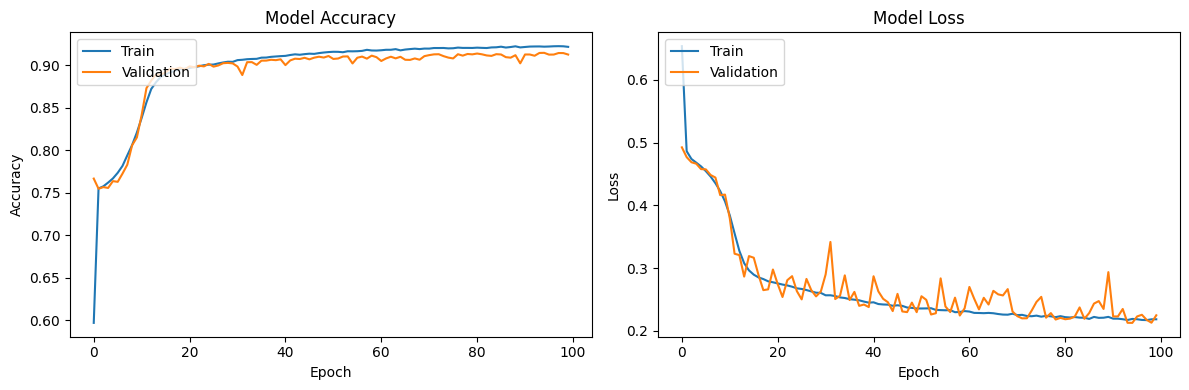

In [52]:
# Plot training
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Assuming `history` is the result of the `fit` method from training your model
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Example usage
# history = classifier.fit(...)  # Train your model and get the history
plot_training_history(history)


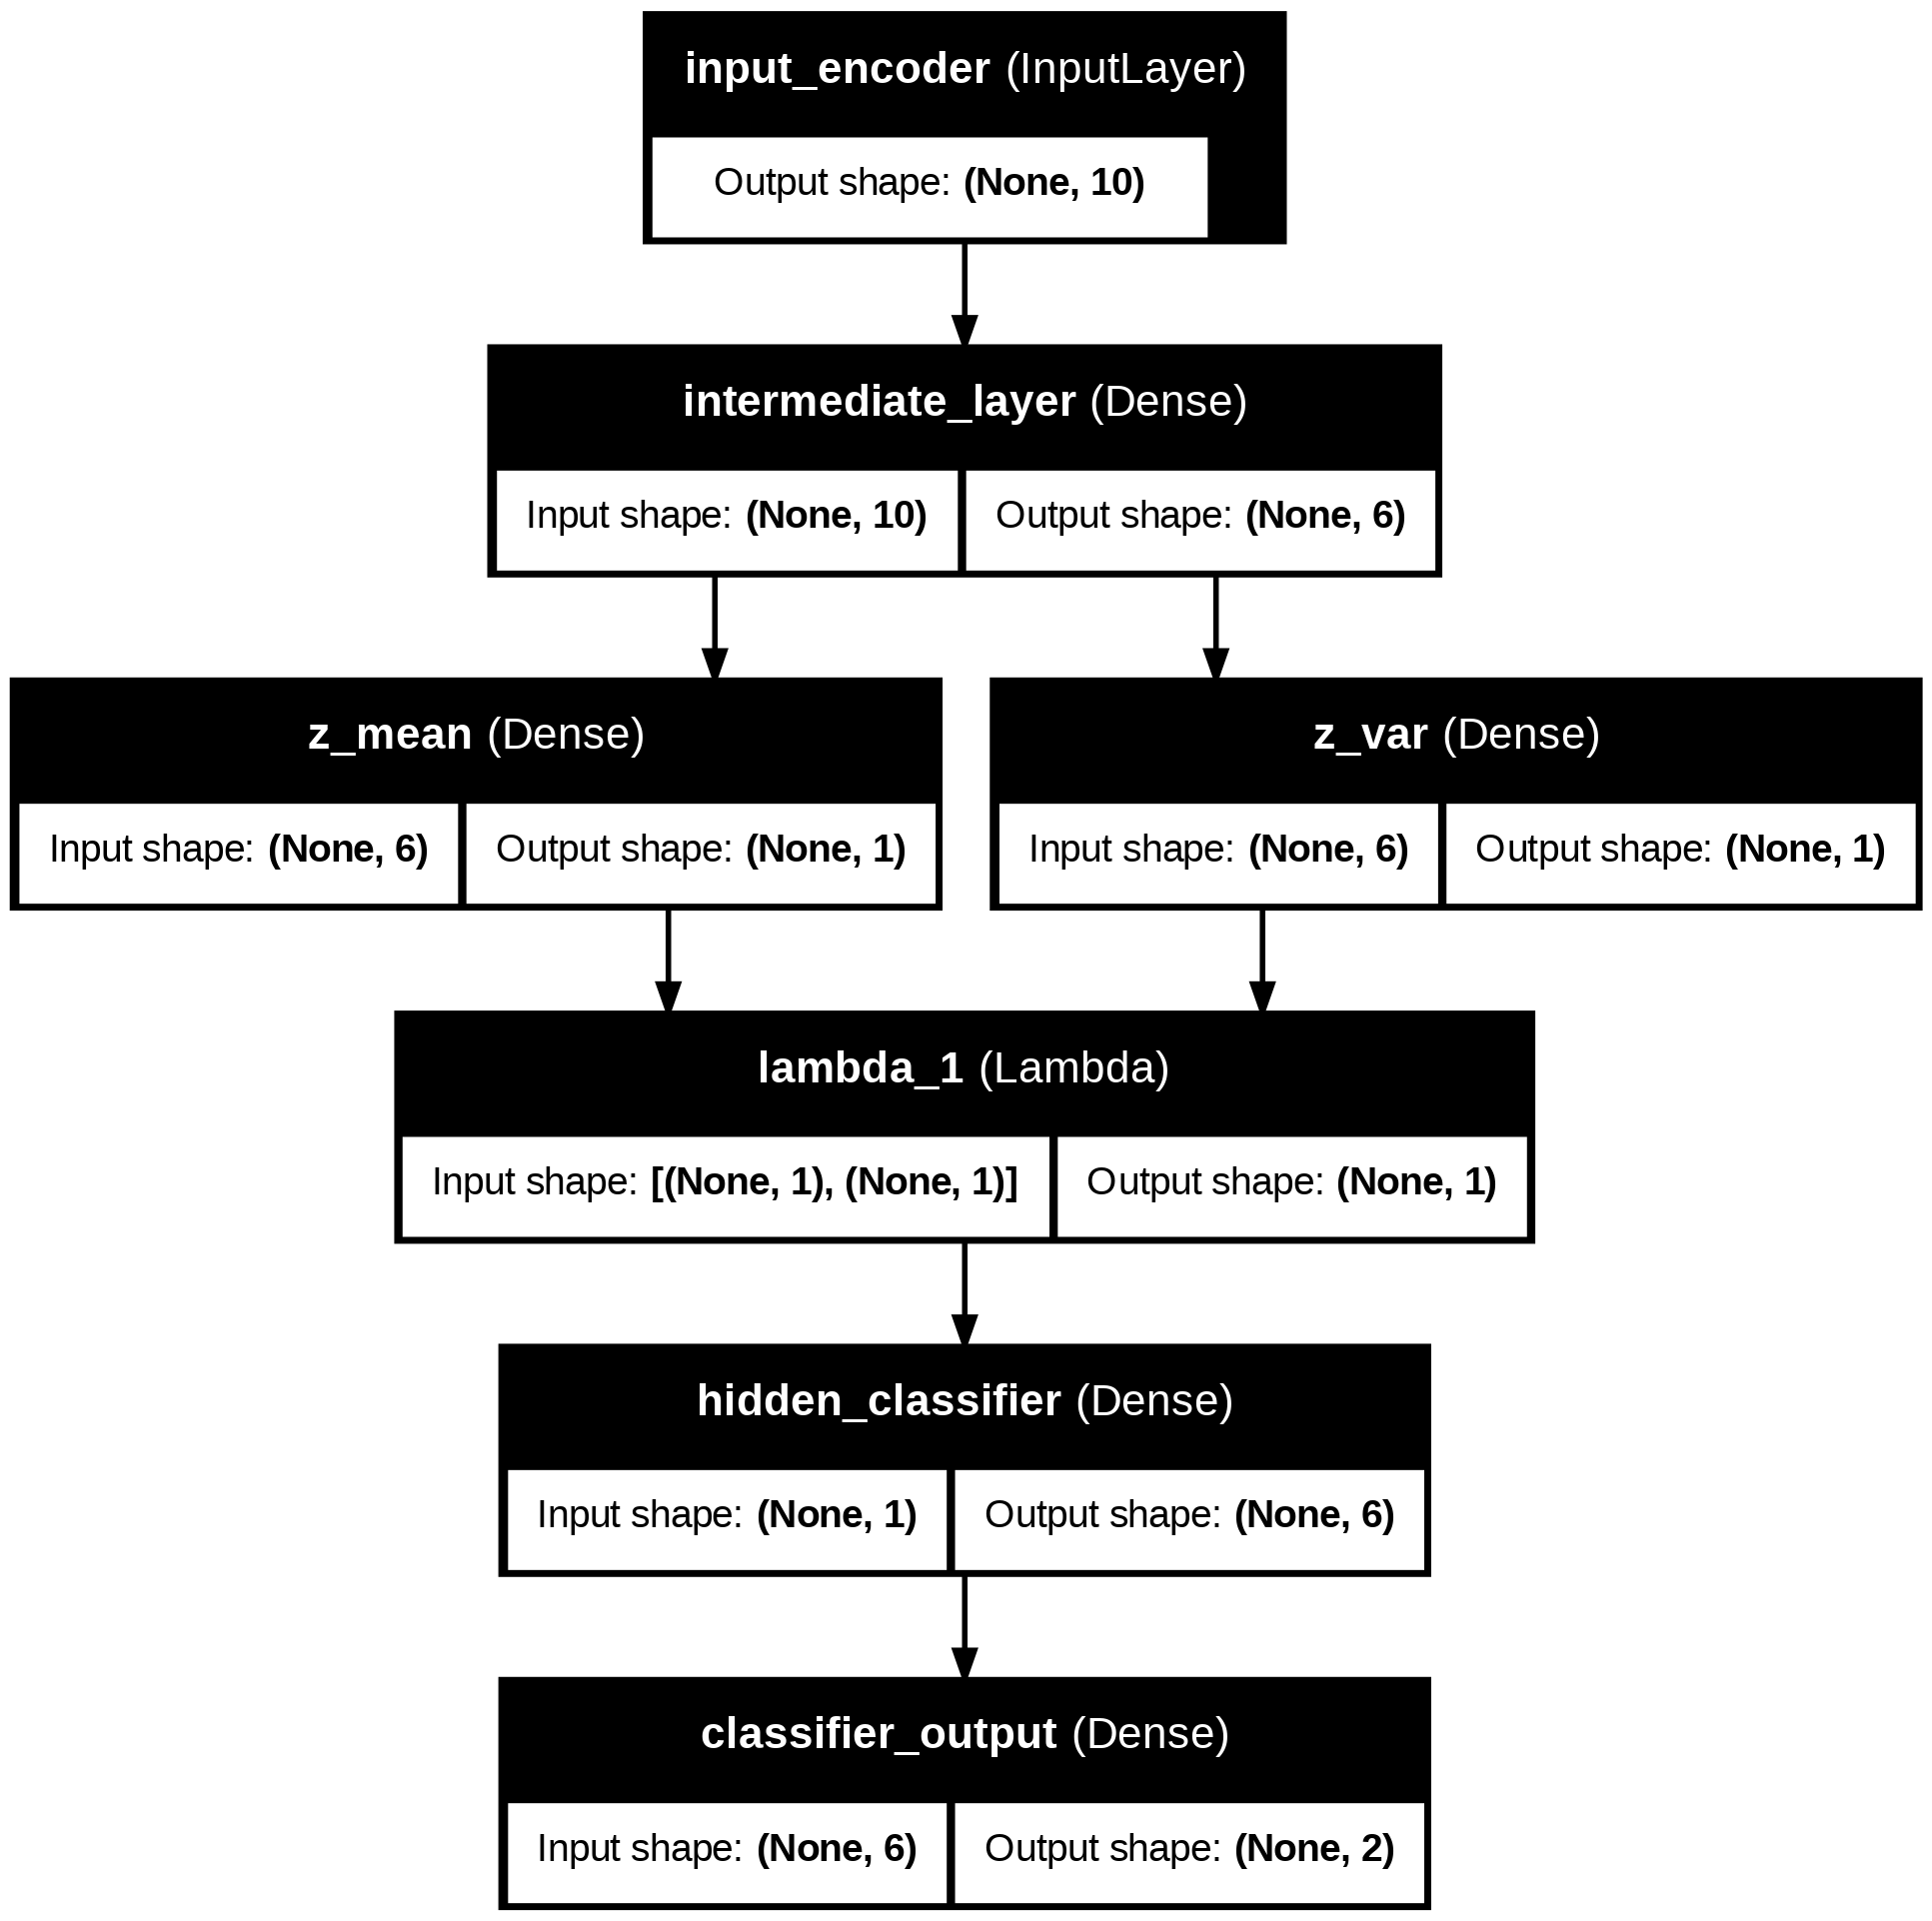

In [53]:
# Print model pake model baru
# Plot model architecture
plot_model(classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [54]:
def print_weights_and_biases(model):
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) == 2:
            weights, biases = weights
            print(f"Layer: {layer.name}")
            print(f"Weights: {weights}")
            print(f"Biases: {biases}\n")
        elif len(weights) == 1:
            # Some layers might only have weights but no biases
            weights = weights[0]
            print(f"Layer: {layer.name}")
            print(f"Weights: {weights}\n")
        else:
            # Layers without weights or biases
            print(f"Layer: {layer.name} has no weights or biases.\n")

# Example usage
print_weights_and_biases(classifier)


Layer: input_encoder has no weights or biases.

Layer: intermediate_layer
Weights: [[ 0.6534264   0.21859674  1.2745217  -1.0222182   0.7077743   0.17227717]
 [-0.20127988  0.4514176  -2.0522668   2.672189    0.80515337  0.37432212]
 [-0.13975152 -0.31581482  2.3408759  -2.3335826  -0.33572876 -0.43321046]
 [-0.8709897   0.12654892 -0.26234385  1.635064    0.9312294  -0.01634913]
 [ 0.647927   -0.24472286 -0.01513885 -1.4235544  -0.27940372 -0.35318562]
 [-1.3046579   0.52666247  0.45172158  2.103228    0.6189593   0.27229634]
 [ 2.3592968  -0.5682007  -1.1892892  -2.4954329   0.41806337 -0.25829604]
 [-1.5002532   0.27253047  0.41295567  2.1604352   0.69707775  0.33440912]
 [ 1.0692248  -0.46117586 -0.43102968 -1.3517272   0.30404046 -0.17390116]
 [ 0.41081432  0.26590595 -0.12813525  0.58229923  0.7379277   0.50835204]]
Biases: [-0.03052479  0.20527796 -0.3793689  -0.7488852   0.7164985   0.49002257]

Layer: z_mean
Weights: [[-1.584273  ]
 [ 0.81312776]
 [-1.252652  ]
 [-2.0995972 ]


In [55]:
print(len(Y_test))

13357


In [56]:
# Output tiap layer

from tensorflow.keras.models import Model
import numpy as np

sample_index = 50  # You can change this to any valid index in the test set

# Get the single input and true label
single_input = X_test[sample_index]
true_label = Y_test[sample_index]

# Misalkan 'classifier' adalah model Anda
layer_outputs = [layer.output for layer in classifier.layers]  # Dapatkan output dari setiap layer
layer_names = [layer.name for layer in classifier.layers]      # Dapatkan nama dari setiap layer

# Buat model untuk mendapatkan output dari setiap layer
for layer_name, layer_output in zip(layer_names, layer_outputs):
    intermediate_layer_model = Model(inputs=classifier.input, outputs=layer_output)
    intermediate_output = intermediate_layer_model.predict(np.array([single_input]))
    print(f"Output dari layer {layer_name}: {intermediate_output}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Output dari layer input_encoder: [[0.89439654 0.9073276  0.8771552  0.9094828  0.8663793  0.9094828
  0.8987069  0.875      0.9073276  0.9030172 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Output dari layer intermediate_layer: [[1.2987001  0.95238316 0.64279824 0.61090565 4.8888254  1.2356675 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Output dari layer z_mean: [[-0.01245421]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Output dari layer z_var: [[5.4555054e-14]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Output dari layer lambda_1: [[-0.012454]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Output dari layer hidden_classifier: [[0.9633027  0.9322157  0.5788307  0.6722269  0.8701092  0.73754865]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Output dari layer classifier_output: [[0.9667639  0.03395815]]


In [57]:
# Range output tiap layer
from tensorflow.keras.models import Model
import numpy as np

# Misalkan 'classifier' adalah model Anda
layer_outputs = [layer.output for layer in classifier.layers]  # Dapatkan output dari setiap layer
layer_names = [layer.name for layer in classifier.layers]      # Dapatkan nama dari setiap layer

# Inisialisasi variabel untuk menyimpan nilai max dan min global
global_max_values = {name: -np.inf for name in layer_names}
global_min_values = {name: np.inf for name in layer_names}

# Loop melalui semua sample index
for sample_index in range(20):
    single_input = X_test[sample_index]

    for layer_name, layer_output in zip(layer_names, layer_outputs):
        intermediate_layer_model = Model(inputs=classifier.input, outputs=layer_output)
        intermediate_output = intermediate_layer_model.predict(np.array([single_input]))

        # Cari nilai terbesar dan terkecil untuk sample ini
        max_value = np.max(intermediate_output)
        min_value = np.min(intermediate_output)

        # Update nilai max dan min global
        if max_value > global_max_values[layer_name]:
            global_max_values[layer_name] = max_value
        if min_value < global_min_values[layer_name]:
            global_min_values[layer_name] = min_value

# Cetak nilai max dan min global untuk setiap layer
for layer_name in layer_names:
    print(f"Layer {layer_name}:")
    print(f"Nilai terbesar global: {global_max_values[layer_name]}")
    print(f"Nilai terkecil global: {global_min_values[layer_name]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

In [79]:
# Testing input
import numpy as np

sample_index = 3  # You can change this to any valid index in the test set

# Get the single input and true label
single_input = X_test[sample_index]
true_label = Y_test[sample_index]

# Print the true label
print(f'Single input for the selected sample: {single_input}')
print(f'True label for the selected sample: {true_label}')

# Assuming X_test is your test data
def test_single_input(model, input_data):
    # Reshape input_data if needed, e.g., input_data = input_data.reshape(1, -1)
    prediction = model.predict(np.array([input_data]))
    print(f"Input: {input_data}")
    print(f"Predicted Output: {prediction[0][0] < prediction[0][1]}")

# Example usage
test_single_input(classifier, X_test[sample_index])


Single input for the selected sample: [0.41613924 0.35601266 0.36392405 0.3971519  0.3528481  0.36234177
 0.38132911 0.27531646 0.54588608 0.40981013]
True label for the selected sample: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Input: [0.41613924 0.35601266 0.36392405 0.3971519  0.3528481  0.36234177
 0.38132911 0.27531646 0.54588608 0.40981013]
Predicted Output: True


In [80]:
false_count = 0
for i in range(500):
  single_input = X_test[i]
  true_label = Y_test[i]
  prediction = classifier.predict(np.array([single_input]))
  prediction_label = prediction[0][0] < prediction[0][1]

  if true_label != prediction_label:
    false_count+=1

print(false_count)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

In [59]:
# # Kode jadul
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Lambda, Layer
# from tensorflow.keras.models import Model
# from tensorflow.keras.losses import mse
# from tensorflow.keras import backend as K

# # Parameters
# input_dim = window_size  # Set this to your input dimension
# latent_dim = 2  # Dimension of the latent space
# intermediate_dim_1 = 16
# intermediate_dim_2 = 8

# # Encoder
# inputs = Input(shape=(input_dim,))
# h1 = Dense(intermediate_dim_1, activation='relu')(inputs)
# h2 = Dense(intermediate_dim_2, activation='relu')(h1)
# z_mean = Dense(latent_dim)(h2)
# z_log_var = Dense(latent_dim)(h2)

# # Reparameterization trick
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# # Decoder
# decoder_h1 = Dense(intermediate_dim_2, activation='relu')
# decoder_h2 = Dense(intermediate_dim_1, activation='relu')
# decoder_mean = Dense(input_dim, activation='sigmoid')  # Use 'sigmoid' if input is normalized [0, 1]

# h_decoded1 = decoder_h1(z)
# h_decoded2 = decoder_h2(h_decoded1)
# x_decoded_mean = decoder_mean(h_decoded2)

# # VAE model
# vae = Model(inputs, x_decoded_mean)

# # Custom loss layer
# class VAELossLayer(Layer):
#     def __init__(self, **kwargs):
#         super(VAELossLayer, self).__init__(**kwargs)

#     def call(self, inputs):
#         x, x_decoded_mean, z_mean, z_log_var = inputs
#         reconstruction_loss = mse(x, x_decoded_mean) * input_dim
#         kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#         self.add_loss(K.mean(reconstruction_loss + kl_loss))
#         return x

# # Apply custom loss layer
# outputs = VAELossLayer()([inputs, x_decoded_mean, z_mean, z_log_var])

# # Final VAE model with custom loss
# vae = Model(inputs, outputs)
# vae.compile(optimizer='adam')

# # To train the model, use:
# # vae.fit(x_train, x_train, epochs=50, batch_size=128)


In [60]:
# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
# # Train the model
# # history = model.fit(
# #     X_train_smote,
# #     Y_train_smote,
# #     epochs=5,
# #     batch_size=32,
# #     validation_split=0.2,
# #     verbose=1
# # )
# # history = vae.fit(X_train_smote,
# #     Y_train_smote,
# #     epochs=50,
# #     batch_size=128,
# #     validation_split=0.2,
# #     verbose=1)

# history = vae.fit(X_train, X_train,  # For VAE, input and output are the same
#                   epochs=50,
#                   batch_size=128,
#                   validation_data=(X_test, X_test))


In [62]:
# # plt.plot(history.history['accuracy'], label='Training accuracy')
# # plt.plot(history.history['val_accuracy'], label='Validation accuracy')
# # plt.title('Training and Validation Accuracy')
# # plt.xlabel('Epochs')
# # plt.ylabel('Accuracy')
# # plt.legend()
# # plt.show()

# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [63]:
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [64]:
# Evaluate the model and print the accuracy
# loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
# print(f'Test accuracy: {accuracy}')
# print(f'Loss: {loss}')

## Exporting the Model

In [65]:
# # Convert the model to the TensorFlow Lite format without quantization
# # converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter = tf.lite.TFLiteConverter.from_keras_model(vae)
# tflite_model = converter.convert()

# # Save the module to a file
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

In [66]:
# !apt-get -qq install xxd
# !xxd -i model.tflite > model.cpp
# !cat model.cpp

In [67]:
# from tensorflow.keras.utils import plot_model
# plot_model(vae, to_file='model.png', show_shapes=True, show_layer_names=True)

In [68]:
# # Example: Print weights and biases for all layers
# # for i, layer in enumerate(model.layers):
# for i, layer in enumerate(vae.layers):
#     print(f"Layer {i + 1}: {layer.name}")
#     weights = layer.get_weights()  # Returns weights and biases as a list
#     if weights:  # Some layers may not have weights (e.g., activation layers)
#         print(f"  Weights: {weights[0].shape}\n{weights[0]}")  # Weight matrix
#         print(f"  Biases: {weights[1].shape}\n{weights[1]}")  # Bias vector
#     else:
#         print("  No weights or biases for this layer.")
#     print()

In [69]:
# # Test kode
# import numpy as np

# # Select a sample index from the test set
# sample_index = 2  # You can change this to any valid index in the test set

# # Get the single input and true label
# single_input = X_test[sample_index]
# true_label = Y_test[sample_index]

# # Print the true label
# print(f'Single input for the selected sample: {single_input}')
# print(f'True label for the selected sample: {true_label}')

# # Reshape the input to include the batch dimension
# single_input = single_input.reshape(1, -1)  # Shape becomes (1, input_dim)

# # Use the model to predict
# prediction = vae.predict(single_input)

# # Print the prediction
# print(f'Prediction for the selected sample: {prediction}')

# # Assuming binary classification
# threshold = 0.5
# predicted_label = (prediction > threshold).astype(int)

# print(f'Predicted label for the selected sample: {predicted_label[0][0]}')
